In [74]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
import time





In [75]:
df = pd.read_csv('/content/bikeshare.csv')

In [76]:
df.head()

,season,yr,mnth,hr,holiday,weekday,notbizday,weathersit,temp,hum,windspeed,dteday,cnt
0,1,0,1,0,0,6,1,1,-1.334609,0.947345,-1.553844,2011-01-01,16
1,1,0,1,1,0,6,1,1,-1.438475,0.895513,-1.553844,2011-01-01,40
2,1,0,1,2,0,6,1,1,-1.438475,0.895513,-1.553844,2011-01-01,32
3,1,0,1,3,0,6,1,1,-1.334609,0.636351,-1.553844,2011-01-01,13
4,1,0,1,4,0,6,1,1,-1.334609,0.636351,-1.553844,2011-01-01,1


In [77]:
df = df.drop('dteday', axis=1)

In [78]:
#1

df['overload'] = (df['cnt'] > 500).astype(int)
overload_proportion = df['overload'].value_counts(normalize=True)
print(overload_proportion)



overload
0    0.926405
1    0.073595
Name: proportion, dtype: float64


In [79]:
df = df.drop('cnt', axis=1)

The target variable is heavily imbalanced.

In [80]:
#2

# Define features (X) and target (y)
X = df.drop('overload', axis=1)
y = df['overload']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1000)

In [81]:
#3.1, 3.2

# Train the RF classification model
rf_model = RandomForestClassifier(random_state=1000)
rf_model.fit(X_train, y_train)

# Generate predicted probabilities and classifications
y_hat_probs = rf_model.predict_proba(X_test)
y_hat = rf_model.predict(X_test)

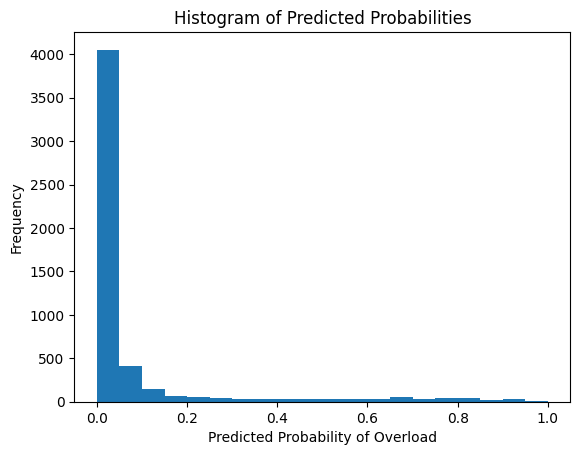

In [82]:
#3.3

plt.hist(y_hat_probs[:, 1], bins=20)
plt.xlabel("Predicted Probability of Overload")
plt.ylabel("Frequency")
plt.title("Histogram of Predicted Probabilities")
plt.show()



The model is doing well at distinguishing between positive and negative cases by its ditinctive seperation of both. It is likelye the threshold is around 0.5 and the model dumps the value into either 0,1 depending on if it meets or exceeds the threshold.

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      4819
           1       0.89      0.71      0.79       395

    accuracy                           0.97      5214
   macro avg       0.93      0.85      0.89      5214
weighted avg       0.97      0.97      0.97      5214



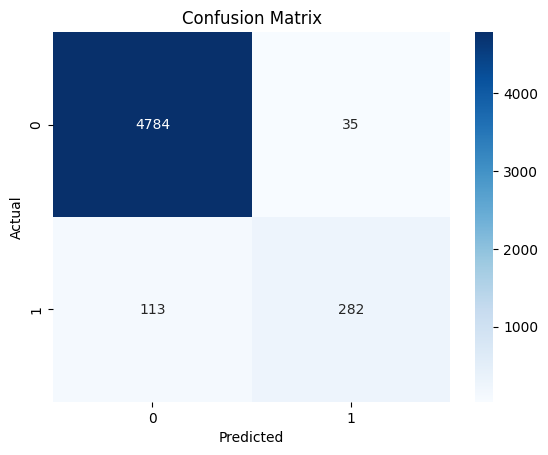

In [83]:
#3.4

# Generate and print the classification report
print(classification_report(y_test, y_hat))

# Generate and plot the confusion matrix
cm = confusion_matrix(y_test, y_hat)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



The model is performing considerably well at first glance. If we care about the cost of false positives more thna anything else, than the model is not necessarily doing fantastic, recall = 0.71. ANd if that is the case we would need to improve the model's ability at caputing the positive class correcetly. The accuracy is obviously high due to the imbalanced nature of the dataset, which means the model is able to predict the majority class most of the time, which results in higher accuracy. The nature of this datset also allows the model to perform exceptionally well on the negative classes, which we can see from the resulting high f1-scores, Precision, and recall values.

In [84]:
#4

# Define the parameter grid
my_param_grid = {'n_estimators':[100,200], 'criterion':['gini','entropy'],  'max_features':['log2', 'sqrt'], 'max_depth':[10,None], 'oob_score':[True]}

# Create and train the RandomForestClassifier with GridSearchCV
rf_model = RandomForestClassifier(random_state=1000)
grid_search = GridSearchCV(estimator=rf_model, param_grid=my_param_grid, cv=5, scoring='f1') #using f1 to address class imbalance
grid_search.fit(X_train, y_train)

# Get the best model and its hyperparameters
best_rf_model = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)

# Evaluate the best model
y_hat_probs = best_rf_model.predict_proba(X_test)
y_hat = best_rf_model.predict(X_test)



Best Hyperparameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 200, 'oob_score': True}


There is a slight improvement in model performance as indicated by the improvement in accuracy. The model is using a bushy tree due to limited amount of features it can select from.

In [85]:
print(classification_report(y_test, y_hat))


              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4819
           1       0.88      0.74      0.80       395

    accuracy                           0.97      5214
   macro avg       0.93      0.86      0.89      5214
weighted avg       0.97      0.97      0.97      5214



In [86]:
#5

# Perform cross-validation
cv_scores = cross_val_score(best_rf_model, X_train, y_train, cv=5, scoring='accuracy')

# Calculate the mean CV accuracy
mean_cv_accuracy = cv_scores.mean()
print(f"Mean Cross-Validation Accuracy: {mean_cv_accuracy}")

# OOB score is available directly from the trained RandomForestClassifier
oob_accuracy = best_rf_model.oob_score_
print(f"Out-of-Bag (OOB) Accuracy: {oob_accuracy}")

# Compare the results
print("\nComparison:")
print(f"- Mean CV Accuracy: {mean_cv_accuracy}")
print(f"- OOB Accuracy: {oob_accuracy}")

Mean Cross-Validation Accuracy: 0.9739416358405262
Out-of-Bag (OOB) Accuracy: 0.9732840115084258

Comparison:
- Mean CV Accuracy: 0.9739416358405262
- OOB Accuracy: 0.9732840115084258


In [87]:
#6

# Create and train a balanced RandomForestClassifier
balanced_rf_model = RandomForestClassifier(random_state=1000, class_weight='balanced')
balanced_rf_model.fit(X_train, y_train)

# Make predictions using the balanced model
y_hat_balanced = balanced_rf_model.predict(X_test)

# Evaluate the balanced model and compare with previous results
print(classification_report(y_test, y_hat_balanced))



              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4819
           1       0.89      0.73      0.80       395

    accuracy                           0.97      5214
   macro avg       0.93      0.86      0.89      5214
weighted avg       0.97      0.97      0.97      5214



The recall saw a tiny dip, which i assume is due to the increase in false negatives from the positive class, now that they classes are balanced.

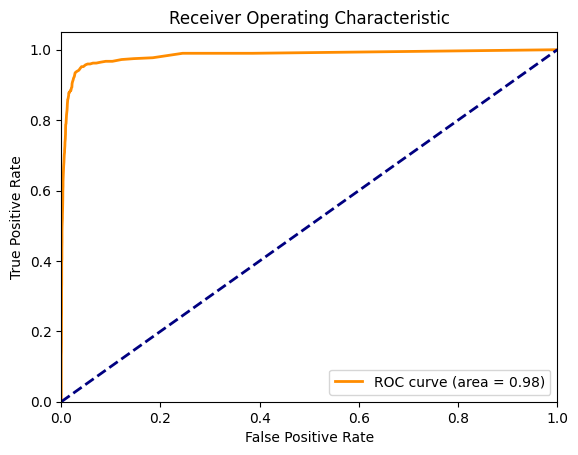

AUC for balanced Random Forest: 0.98


In [88]:
#7

# Predict probabilities for the positive class (overload)
y_probs_balanced = balanced_rf_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs_balanced)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print(f"AUC for balanced Random Forest: {roc_auc:.2f}")


Yes, this AUC curve accoutns for the balnced classes now, which it didn't beforehand.

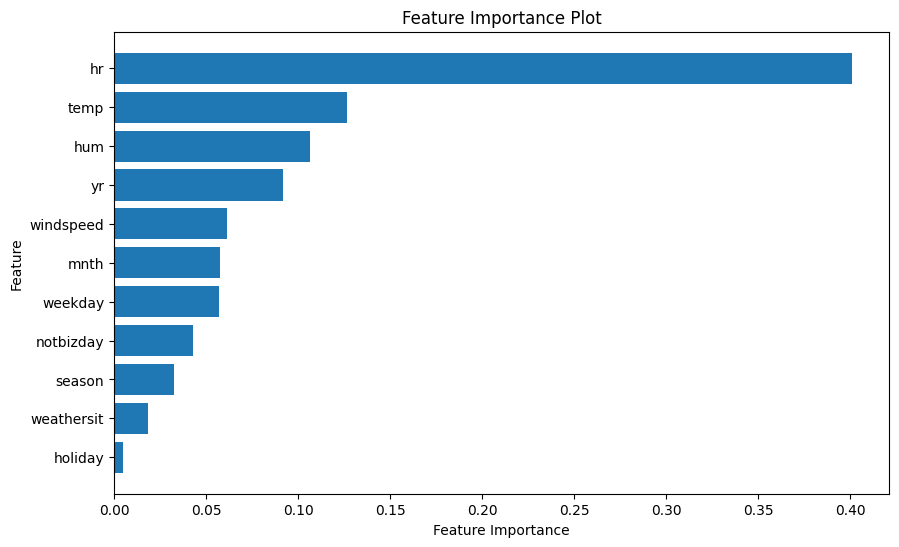

Top 5 Important Features:


,Feature,Importance
3,hr,0.400887
8,temp,0.126497
9,hum,0.106514
1,yr,0.091625
10,windspeed,0.061317


In [89]:
#8

feature_importances = best_rf_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)


# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Plot')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

# Report top 5 features
top_5_features = feature_importance_df.head(5)
print("Top 5 Important Features:")
top_5_features



I am not familiar with biking rentals and what drives people to rent bikes. I would imagine weather, wind, how long they are going to sue the rentals for would all be common sense features. The graph displays that, so to my knowledge the feature importance plot makes sense.

In [90]:
#9

def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    start_time = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    end_time = time.time()
    execution_time = end_time - start_time
    return f1, execution_time


# Models to evaluate
models = {
    "AdaBoost": AdaBoostClassifier(random_state=1000),
    "GBM": GradientBoostingClassifier(random_state=1000),
    "XGBoost": XGBClassifier(random_state=1000, use_label_encoder=False, eval_metric='logloss'),
    "Random Forest": RandomForestClassifier(random_state=1000, class_weight='balanced')
}

results = []
for model_name, model in models.items():
    f1, execution_time = train_and_evaluate(model, X_train, y_train, X_test, y_test)
    results.append([model_name, f1, execution_time])


results_df = pd.DataFrame(results, columns=["Model", "F1-Score", "Execution Time"])
results_df = results_df.sort_values(by="Execution Time")

print("Model Ranking by Execution Speed:")
print(results_df)

results_df = results_df.sort_values(by="F1-Score", ascending=False)
print("\nModel Ranking by Performance (F1-Score):")
print(results_df)



/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:54:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model Ranking by Execution Speed:
           Model  F1-Score  Execution Time
2        XGBoost  0.861619        0.174829
0       AdaBoost  0.603318        0.448632
3  Random Forest  0.800558        0.887491
1            GBM  0.778098        1.276309

Model Ranking by Performance (F1-Score):
           Model  F1-Score  Execution Time
2        XGBoost  0.861619        0.174829
3  Random Forest  0.800558        0.887491
1            GBM  0.778098        1.276309
0       AdaBoost  0.603318        0.448632


XGboost is the fastest in execution time, as it is built for computational efficiency, as expected and leads in f1 score.